In [1]:
import sys
import numpy as np
import torch 
# still do preprocessing in scipy
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# import factor model from beta-dirichlet-factor
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/beta-dirichlet-factor')
import factor_model

In [2]:
leaflet_repo = '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/'
sys.path.append(leaflet_repo)
import load_cluster_data
from betabinomo_mix_singlecells import *

### Settings and Load data

In [3]:
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

cpu


In [4]:
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'

cell_types = ['Brain_Non-Myeloid_brain_pericyte','Brain_Non-Myeloid_oligodendrocyte_precursor_cell','Brain_Non-Myeloid_endothelial_cell','Brain_Non-Myeloid_oligodendrocyte',
 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage',
 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']

#ignoring Bergmann_glial_cell since very few cells

# convert data to Leaflet required input formats 
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, max_intron_count=5000, celltypes=cell_types, has_genes="yes") 

# add cluster to final_data 
final_data = final_data.merge(junction_ids_conversion, on=["junction_id_index"], how="left")

# get indices (maybe don't need this actually)
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/
Finished reading in data from folder ...
Looking at only specific cell types ...['Brain_Non-Myeloid_brain_pericyte', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_endothelial_cell', 'Brain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage', 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']
['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']
7816
16190
The maximum junction count was initially:  150346
80
The maximum junction count is now:  4982
                                             cell_id  Cluster  Cluster_Counts  \
0  A14-MAA000581-3_10_M-1-1_Brain_Non-M

In [5]:
cell_index_tensor, junc_index_tensor, my_data = make_torch_data(final_data, **float_type)

The number of cells going into training data is:
7816
7816


/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/betabinomo_mix_singlecells.py:333: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  ycount_lookup = torch.sparse_coo_tensor(


In [6]:
simple_data = final_data[["cell_id_index", "Cluster", "cell_type", "junction_id_index", "juncratio", "junc_count", "cluster_count",  "junction_id", "gene_id"]]
#sns.kdeplot(data=final_data, x="juncratio", hue="cell_type", cumulative=True, common_norm=False, common_grid=True)

### Start with a simple PCA using imputed values 

In [ ]:
# make matrix of junctions by cells and fill with juncratio values 
mat = np.zeros((len(final_data.cell_id_index.unique()), len(final_data.junction_id_index.unique())))
mat[final_data.cell_id_index, final_data.junction_id_index] = final_data.juncratio
mat[~(final_data.cell_id_index), ~(final_data.junction_id_index)] = np.nan

# imput nan values using mean of each row (does this make sense?)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(mat)
mat_imputed = imp.transform(mat)

# run PCA on mat_imputed 
pca = PCA(n_components=10)
pca.fit(mat_imputed)
print(pca.explained_variance_ratio_)

In [ ]:
pcs = pca.transform(mat_imputed)
pcs_df = pd.DataFrame(pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])
cell_types_pcs = cell_ids_conversion["cell_type"]

In [ ]:
# plot first two PCs
sns.scatterplot(data=pcs_df, x="PC1", y="PC2", hue=cell_types_pcs.values, s=5, alpha=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("PCA of Junction Usage Ratios (imputed matrix)")

In [ ]:
# plot first and third PCs
sns.scatterplot(data=pcs_df, x="PC2", y="PC3", hue=cell_types_pcs.values, s=5, alpha=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("PCA of Junction Usage Ratios (imputed matrix)")

### Take a quick look at coverage of reads across junctions

In [ ]:
cell_junc_cov = final_data.groupby("cell_id_index").junc_count.sum()
cell_cluster_cov = final_data.groupby("cell_id_index").cluster_count.sum()

# plot histogram of coverage
sns.histplot(cell_junc_cov/1000)
plt.title("Junction Coverage per Cell (read counts/1000)")

In [ ]:
# plot histogram of coverage clusters 
sns.histplot(cell_cluster_cov/1000)
plt.title("Cluster Coverage per Cell (read counts/1000)")

### Get ready for model training 

In [ ]:
if device == torch.device('cuda'):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
indices = torch.tensor(final_data[['cell_id_index', 'junction_id_index']].to_numpy().T, dtype=torch.long)
values = torch.tensor(final_data['junc_count'].to_numpy(), dtype=torch.float)
# Determine the size of the tensor
num_cells = final_data['cell_id_index'].max() + 1
num_junctions = final_data['junction_id_index'].max() + 1
size = (num_cells, num_junctions)
# Create a sparse tensor
y_tensor = torch.sparse_coo_tensor(indices, values, size)

In [ ]:
indices_counts = torch.tensor(final_data[['cell_id_index', 'junction_id_index']].to_numpy().T, dtype=torch.long)
values_counts = torch.tensor(final_data['cluster_count'].to_numpy(), dtype=torch.float)
# Determine the size of the tensor
num_cells_counts = final_data['cell_id_index'].max() + 1
num_junctions_counts = final_data['junction_id_index'].max() + 1
size_counts = (num_cells_counts, num_junctions_counts)
# Create a sparse tensor
total_counts_tensor = torch.sparse_coo_tensor(indices_counts, values_counts, size_counts)

### Run factor model!

In [ ]:
# import reload 
from importlib import reload
reload(factor_model)

In [ ]:
# When set K to 100, error pops up after 270 iterations of training 
# with global priors -> SS of 0.02
# with no prior on PSI 

In [ ]:
K = 100
losses, sampled_guide, latent_vars = factor_model.main(y_tensor, total_counts_tensor, use_global_prior=True, K=K, lr=0.1, loss_plot=True, num_epochs=100)

In [ ]:
# extract latent variables
pi = latent_vars["pi"] # overall contribution of each factor to cell population
conc = latent_vars["conc"] # one scaling value 

assign_post = latent_vars["assign"]

psis = latent_vars["psi"] # psi is the probability of a junction being used in a cluster
a = latent_vars["a"] # a is the alpha parameter of the beta distribution (if no global prior used, then this is one value per junction)
b = latent_vars["b"] # b is the beta parameter of the beta distribution (if no global prior used, then this is one value per junction)

#a_global = latent_vars["a_global"] # a_global is the alpha parameter of the beta distribution (if global prior used, then this is one value for all junctions)
#b_global = latent_vars["b_global"] # b_global is the beta parameter of the beta distribution (if global prior used, then this is one value for all junctions)

In [ ]:
# plot histogram of pi values 
sns.histplot(pi)

In [ ]:
print(a.shape)
print(b.shape)

In [ ]:
print("The inferred concentration parameter is: " + str(conc))
print("The inferred pi parameter is: " + str(pi))

In [ ]:
mu=a/(a+b)
s=a+b

print(mu)
print(s)

### Evaluate latent variables 

In [ ]:
color_palette = sns.color_palette("Set1", n_colors=len(cell_ids_conversion['cell_type'].unique()))
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_ids_conversion['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_types = cell_ids_conversion.cell_type.values

# create colours for each cell type 
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

In [ ]:
assign_post.shape

In [ ]:
cluster = sns.clustermap(
    data=assign_post,
    method='complete',
    cmap="viridis",
    annot=False,
    fmt=".2f",
    yticklabels=False,
    figsize=(8, 8),
    center=0,
    row_colors=row_colors,  # Apply row colors
    cbar_kws={'label': 'Post assignment'} 
    )
cluster.cax.set_ylabel('Post assignment', size=8)
# Increase font size for color bar tick labels:
cbar_ax = cluster.cax
for label in cbar_ax.yaxis.get_ticklabels():
    label.set_size(8)

In [ ]:
# print cell type color legend seperately
cell_type_colors
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)
sns.palplot(color_palette)
plt.title("Cell Type Legend")
# add cell type names to legend
plt.xticks(np.arange(len(unique_cell_types)), unique_cell_types, rotation=45, ha='right')
plt.xlabel("Cell Type")


In [ ]:
# let's calculate silhouette score ussing assign_post
ss = silhouette_score(assign_post, cell_types)
# print with K equals K the ss is 
print("The silhouette score for K = " + str(K) + " is: " + str(ss))

In [ ]:
# let's plot junction usage across factors using heatmap
# get junction usage for factor 1
factor_junc_usage = psis[1:8000, :]
factor_junc_usage
# make heatmap to visualize junction usage across factors
sns.clustermap(factor_junc_usage, cmap="viridis")

In [ ]:
psis.shape

In [ ]:
psis.shape

In [ ]:
# make histogram from np array to visualize distribution of probabilities for junction usages across factors 
# Number of factors (columns)
num_factors = psis.shape[0]

# Plotting KDE cumulative plot for each column
for i in range(num_factors):
    sns.kdeplot(psis[i, :], cumulative=True, label=f'Factor {i+1}')

plt.title('Latent junction PSIs across factors')
plt.xlabel('Junction-Factor PSI')
plt.ylabel('Cumulative Density')
plt.axhline(y=0.5, color='red', linestyle='--')
plt.show()

In [ ]:
junc_counts.shape

In [ ]:
cluster_counts

## Evaluate perfomrance on imputation/masking task

In [72]:
# import factor model from beta-dirichlet-factor
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/evaluations')
import masking
from masking import *

In [73]:
# import reload 
from importlib import reload
reload(masking)

<module 'masking' from '/gpfs/commons/home/kisaev/Leaflet/src/evaluations/masking.py'>

In [69]:
#1. get masked matrix using intron cluster counts for this mouse brain data 
masks = generate_mask(cluster_counts)

Masked indices:  tensor([117408269, 106544114,  32023343,  ...,  16161691,   9466006,
         83695050])


In [74]:
#2. get junction and intron cluster count matrices with masked values 
masked_junction_counts, masked_intron_clusts = apply_mask(junc_counts, cluster_counts, masks)

In [75]:
#3. get input files for factor model (junction and intron cluster sparse tensor)
y_tensor, total_counts_tensor = prep_model_input(masked_junction_counts, masked_intron_clusts)

In [76]:
y_tensor

tensor(indices=tensor([[    0,     0,     0,  ...,  7815,  7815,  7815],
                       [    0,     1,     2,  ..., 15889, 15903, 15921]]),
       values=tensor([11., 10., 16.,  ...,  0.,  0.,  0.]),
       size=(7816, 15929), nnz=9489760, layout=torch.sparse_coo)

In [77]:
total_counts_tensor

tensor(indices=tensor([[    0,     0,     0,  ...,  7815,  7815,  7815],
                       [    0,     1,     2,  ..., 15889, 15903, 15921]]),
       values=tensor([21., 21., 16.,  ..., 31., 29., 31.]),
       size=(7816, 15929), nnz=9489760, layout=torch.sparse_coo)

Epoch 0, Loss: 234738382.1038659
Epoch 10, Loss: 134540865.22459766
Epoch 20, Loss: 91527235.5729742
Epoch 30, Loss: 73003868.6637435
Epoch 40, Loss: 64530919.061581135
Epoch 50, Loss: 60487939.36831999
Epoch 60, Loss: 58548297.752251744
Epoch 70, Loss: 57437438.68340051
Epoch 80, Loss: 56757957.338353276
Epoch 90, Loss: 56261020.63451779


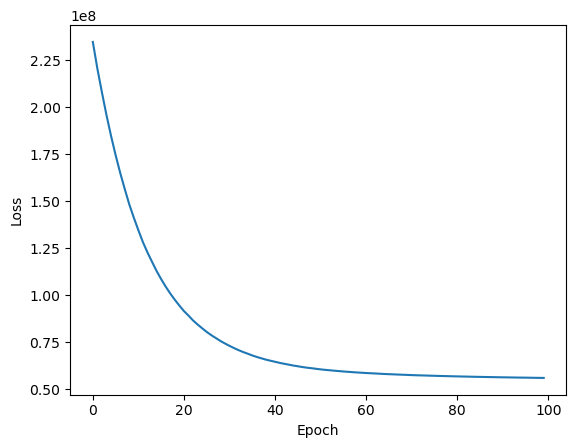

Done! Returning losses, sampled_guide, and latent_vars.


In [78]:
# Now can run factor model on masked data
K = 8
losses, sampled_guide, latent_vars = factor_model.main(y_tensor, total_counts_tensor, use_global_prior=False, K=K, lr=0.1, loss_plot=True, num_epochs=100)

In [79]:
# get latent variables
pi = latent_vars["pi"] # overall contribution of each factor to cell population
conc = latent_vars["conc"] # one scaling value
psi = latent_vars["psi"] # psi is the probability of a junction being used in a cluster
a = latent_vars["a"] # a is the alpha parameter of the beta distribution (if no global prior used, then this is one value per junction)
b = latent_vars["b"] # b is the beta parameter of the beta distribution (if no global prior used, then this is one value per junction)
assign_post=latent_vars["assign"]

In [80]:
pi, conc

(array([0.37730145, 0.11104967, 0.09963002, 0.08261578, 0.06818659,
        0.06696493, 0.12163274, 0.07261881], dtype=float32),
 array(2.931182, dtype=float32))

In [82]:
a.shape, b.shape

((15929,), (15929,))

In [84]:
assign_post.shape

(7816, 8)

In [88]:
psi.shape K x J 

(8, 15929)

In [ ]:
# To recover the original matrix, we need to multiply the factor matrix by the factor loadings

